In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy

In [25]:
from guide.dataset import GuideDataset

# Guide RNA Clustering Homework

First let's import the dataset. I'm using wrapper classes to represent the data so we can interact with it in an object-oriented fashion.

In [26]:
guide_dataset = GuideDataset('data/example_guide_data_with_bowtie_with_mfold.tsv')
points = guide_dataset.points()

In [27]:
gene_names = [p.row['gene_name'] for p in points]
print(len(gene_names))
print(len(set(gene_names)))

64076
17419


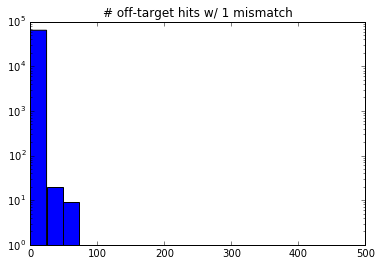

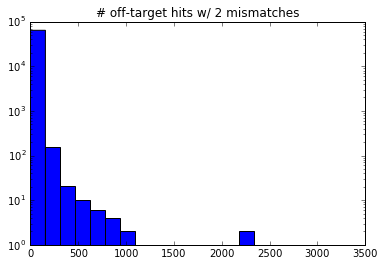

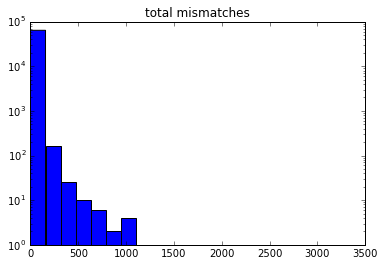

In [28]:
mm_counts = [len(p.bowtie_result().matches()[1:]) for p in points]
mm1_counts = [p.bowtie_result().mismatch_counts()[1] for p in points]
mm2_counts = [p.bowtie_result().mismatch_counts()[2] for p in points]
plt.hist(mm1_counts, bins=20, log=True)
plt.title('# off-target hits w/ 1 mismatch')
plt.show()

plt.hist(mm2_counts, bins=20, log=True)
plt.title('# off-target hits w/ 2 mismatches')
plt.show()

plt.hist(mm_counts, bins=20, log=True)
plt.title('total mismatches')
plt.show()

## Inputs and Outputs

For this problem, the inputs are the spacer sequences, and the outputs (what we would like to predict from the inputs) are their activities -- essentially their effect on the population of cells. 

First let's try to look for some clusters in the activity outputs. We have data for the normalized count of cells still containing the spacer sequences after 0, 7, and 14 days, with and without the drug PLX. If CRISPR knocks out a gene essential for the cell's survival, we expect a spacer's activity (which I've negated here for intuitiveness) to be negative. In the presence of PLX, if CRISPR knocks out a gene that was preventing the cell from resisting PLX, we expect the activity below to be positive.

In [76]:
def plt_activity_histogram(key, points, color=None):
    plt.hist(numpy.array([getattr(p, key)() for p in points]), 50, range=(-10, 10), color=color, label=key, log=True)

In [77]:
def compare_activities(da, db, points, title=None):
    plt_activity_histogram('d{}_d{}_base_activity'.format(da, db), points)
    plt_activity_histogram('d{}_d{}_plx_activity'.format(da, db), points, color=(1, 1, 0.5, 0.5))
    plt.legend()
    plt.axvline(color='red')
    if title is None:
        title = 'D{} vs D{}'.format(da, db)
    plt.title(title)
    plt.show()

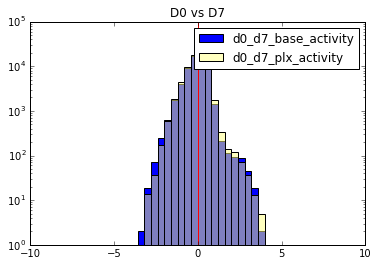

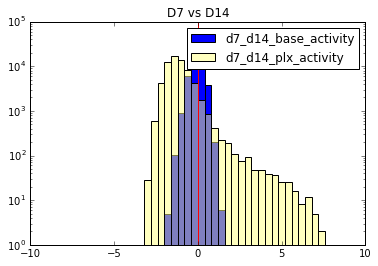

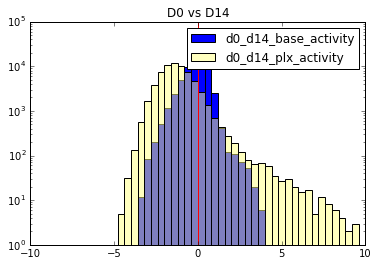

In [78]:
compare_activities(0, 7, points)
compare_activities(7, 14, points)
compare_activities(0, 14, points)

As we might expect, the PLX results show a bias towards the positive for certain sequences (meaning they successfully knocked out genes to give the cell resistance), and towards the negative for others (since PLX is toxic, any spacer sequence that wasn't effective should be suppressed). However, I was expecting to see more of a discrete segmentation between sequences that worked (gave the cell resistance) and sequences that didn't. Graph-wise, I was expecting two peaks, one slightly below 0 and one somewhere up higher. Here, though, we have a more-or-less exponential decay, making it harder to interpret the effect of the spacers as a boolean did-it-work-or-not outcome.

Also interesting is the fact that the PLX-induced die-offs only seemed to happen between D7 and D14; the D0 to D7 results with and without PLX look identical. Perhaps PLX is very slow-acting, or maybe the experimenters waited until D7 to add it?

The base, non-PLX results are a bit harder to interpret. The histogram seems pretty centered around 0, meaning that the spacers could either increase or decrease cells' survival rates. My first instinct was to interpret this as just experimental noise; but the shape of the histogram isn't perfectly symmetrical, and the histogram gets thinner between D7 and D14 (indicating some kind of equilibrium is reached), and the asymmetrical shape between D0 and D7 is replicated almost perfectly by the PLX results. So something is going on.

In [55]:
foldable_points = list(filter(lambda p: p.mfold_result().dG < 900, points))

In [181]:
melting_temps = [p.mfold_result().Tm for p in foldable_points]
free_energies = [p.mfold_result().dG for p in foldable_points]
fold_entropies = [p.mfold_result().dS for p in foldable_points]
fold_enthalpies = [p.mfold_result().dH for p in foldable_points]
plx_activities = [p.d0_d14_plx_activity() for p in foldable_points]
base_activities = [p.d0_d14_base_activity() for p in foldable_points]
hairpin_stems = [p.mfold_result().hairpin_stem_length() for p in foldable_points]
hairpin_loops = [p.mfold_result().hairpin_loop_length() for p in foldable_points]
hairpin_starts = [p.mfold_result().hairpin_start_index() for p in foldable_points]
mm_counts = [len(p.bowtie_result().matches()[1:]) for p in foldable_points]

-4.9435536023614555

In [58]:
from matplotlib.colors import LogNorm

def activity_2dhist(x, y):
    plt.hist2d(eval(x), eval(y), bins=40, norm=LogNorm())
    plt.title('{} vs {}'.format(x, y))
    plt.xlim(-10,10)
    if y == 'free_energies':
        plt.ylim(-15,15)
    elif y == 'melting_temps':
        plt.ylim(-150,150)
    plt.axvline(color='black')
    plt.axhline(color='black')
    plt.colorbar()

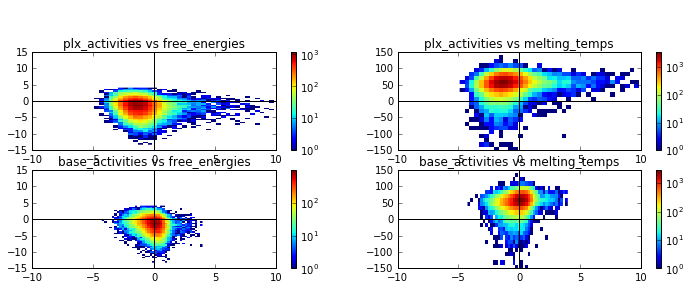

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(3,2,1)
activity_2dhist('plx_activities', 'free_energies')
plt.subplot(3,2,2)
activity_2dhist('plx_activities', 'melting_temps')
plt.subplot(3,2,3)
activity_2dhist('base_activities', 'free_energies')
plt.subplot(3,2,4)
activity_2dhist('base_activities', 'melting_temps')
plt.show()

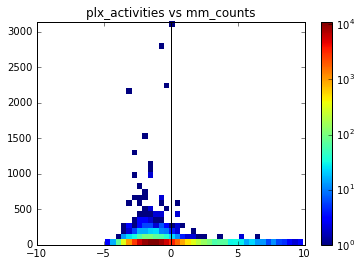

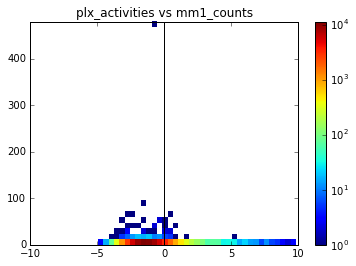

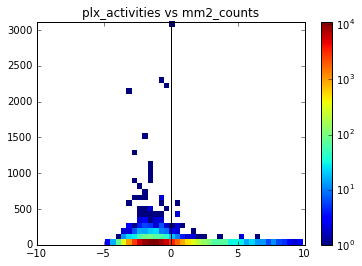

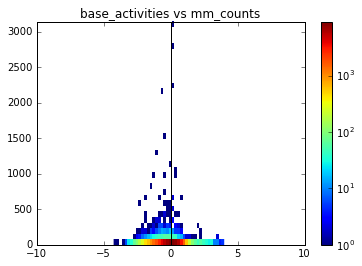

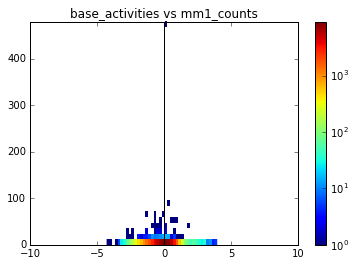

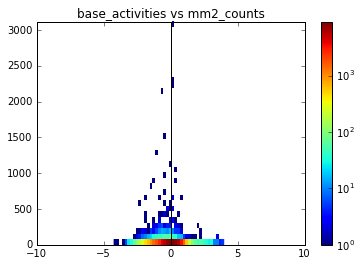

In [69]:
mm_counts = [len(p.bowtie_result().matches()[1:]) for p in foldable_points]
mm1_counts = [p.bowtie_result().mismatch_counts()[1] for p in foldable_points]
mm2_counts = [p.bowtie_result().mismatch_counts()[2] for p in foldable_points]
activity_2dhist('plx_activities', 'mm_counts')
plt.show()
activity_2dhist('plx_activities', 'mm1_counts')
plt.show()
activity_2dhist('plx_activities', 'mm2_counts')
plt.show()
activity_2dhist('base_activities', 'mm_counts')
plt.show()
activity_2dhist('base_activities', 'mm1_counts')
plt.show()
activity_2dhist('base_activities', 'mm2_counts')
plt.show()

In [64]:
mm_counts[0]

1

In [153]:
def split_activities_by(quantity, value, name, outlier_remover=None):
    if outlier_remover is None: outlier_remover = lambda val: True
    plt.hist(list(quantity(p) for p in filter(outlier_remover, points)), 40, log=True)
    plt.title(name)
    plt.show()
    compare_activities(0, 14, list(filter(lambda p: quantity(p) <= value, points)), title=name + ' <= ' + str(value))
    compare_activities(0, 14, list(filter(lambda p: quantity(p) > value, points)), title=name + ' > ' + str(value))

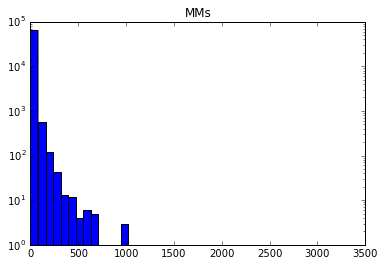

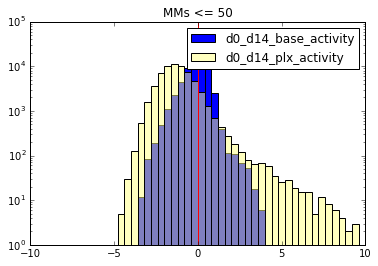

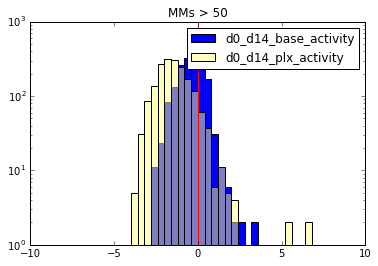

In [144]:
split_activities_by(lambda p: len(p.bowtie_result().matches()[1:]), 50, 'MMs')

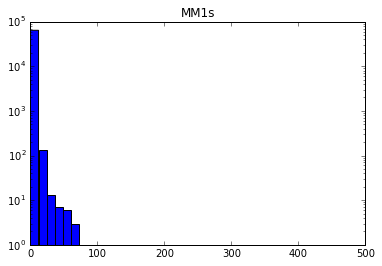

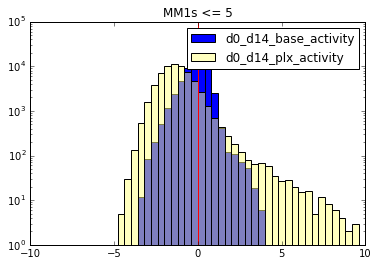

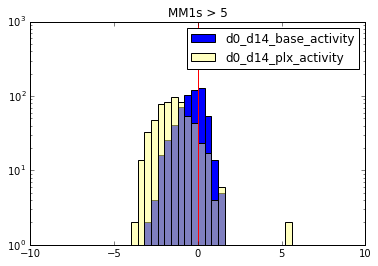

In [141]:
split_activities_by(lambda p: p.bowtie_result().mismatch_counts()[1], 5, 'MM1s')

Number of close mismatches seems to be a strong predictor of guide _inactivity_. This fits with the commonsense idea that CRISPR won't work at all when there are many off-target matches.

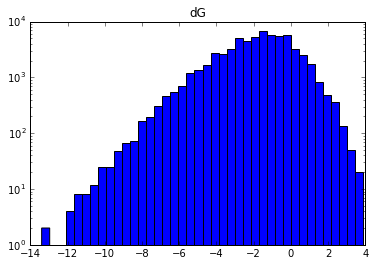

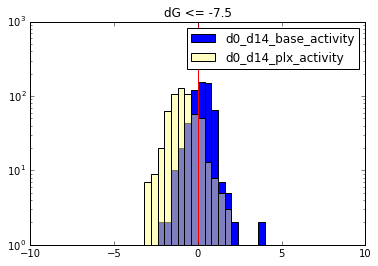

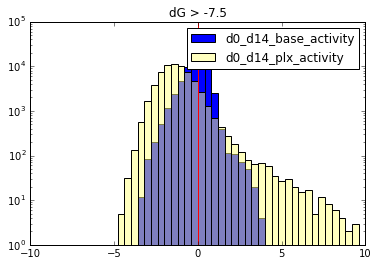

In [155]:
split_activities_by(lambda p: p.mfold_result().dG , -7.5, 'dG', lambda p: p.mfold_result().dG < 900)

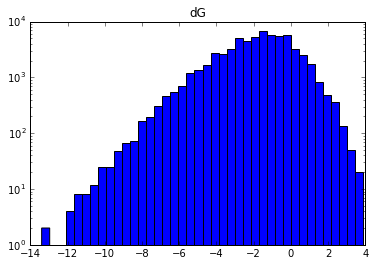

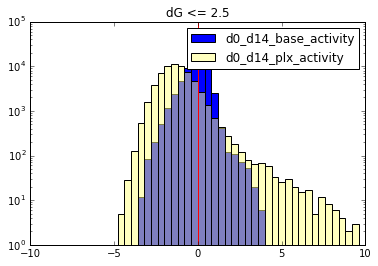

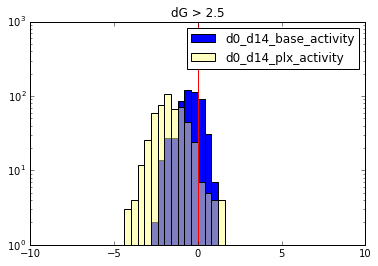

In [156]:
split_activities_by(lambda p: p.mfold_result().dG , 2.5, 'dG', lambda p: p.mfold_result().dG < 900)

Another interesting result. The mfold-computed free energy of the fold seems to need to be in (-7.5, 2.5) for the guide to have an effect. Another win for predicting true negatives.

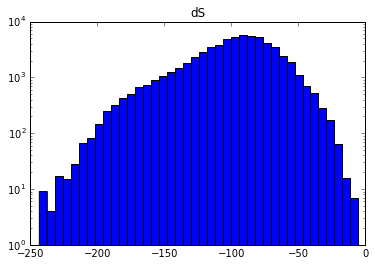

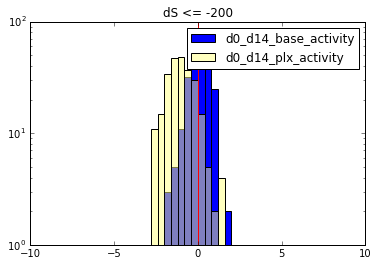

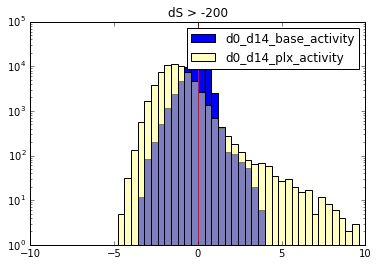

In [163]:
split_activities_by(lambda p: p.mfold_result().dS , -200, 'dS', lambda p: p.mfold_result().dG < 900)

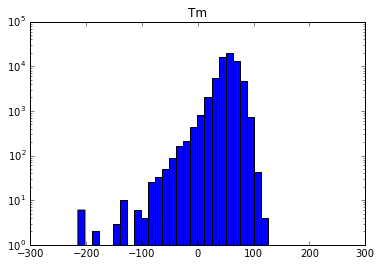

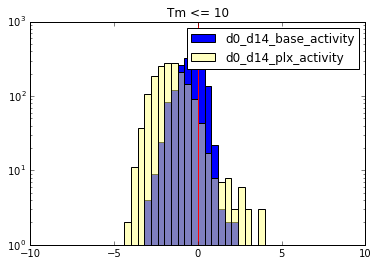

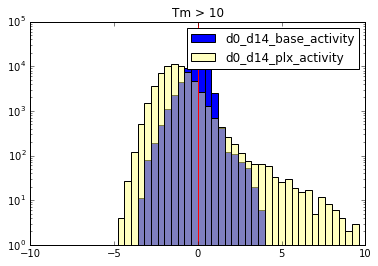

In [174]:
split_activities_by(lambda p: p.mfold_result().Tm , 10, 'Tm', lambda p: p.mfold_result().dG < 900)

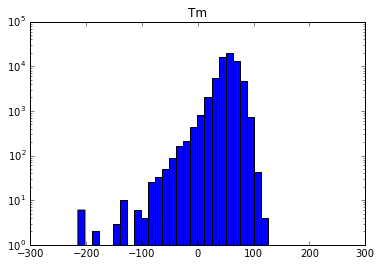

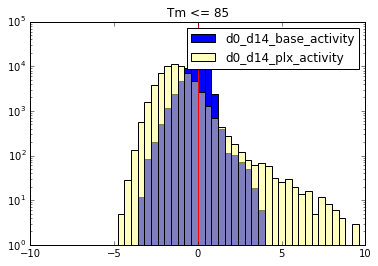

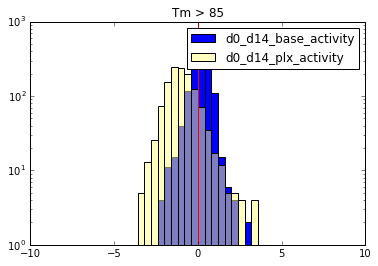

In [173]:
split_activities_by(lambda p: p.mfold_result().Tm, 85, 'Tm', lambda p: p.mfold_result().dG < 900)

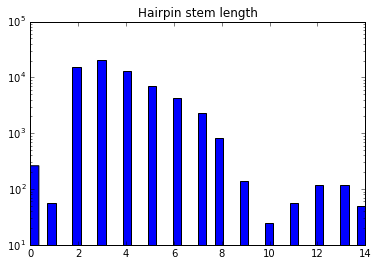

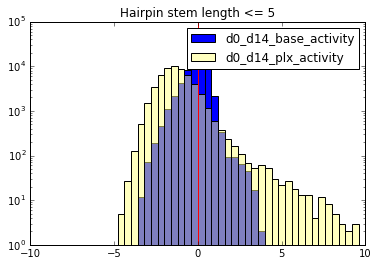

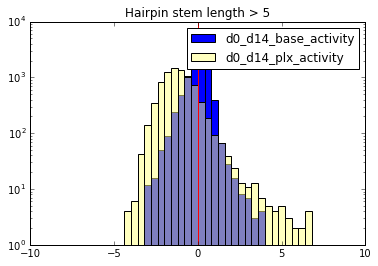

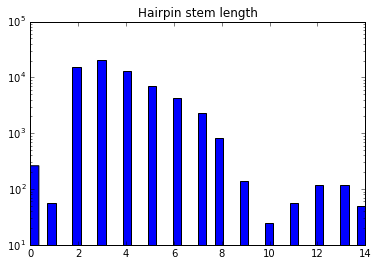

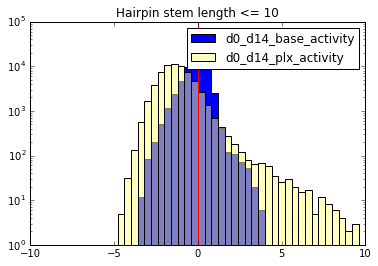

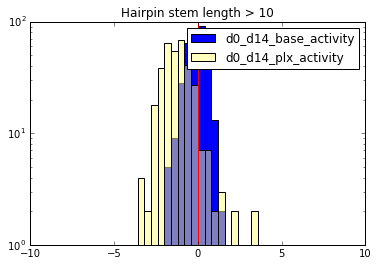

In [151]:
def stem_length(p):
    try:
        return p.mfold_result().hairpin_stem_length()
    except:
        return 0
split_activities_by(stem_length, 5, 'Hairpin stem length')
split_activities_by(stem_length, 10, 'Hairpin stem length')

If the RNA is excessively hairpinned, that also seems to hurt. A hairpin stem length of 10 is pretty huge though, given the strand is only 20bp long.

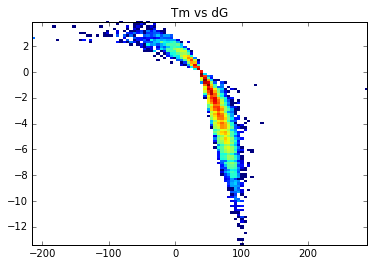

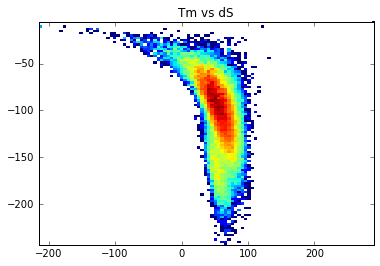

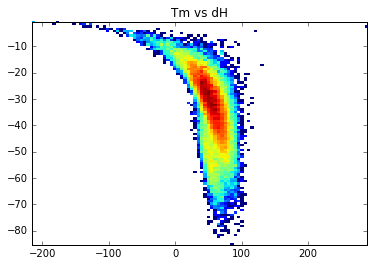

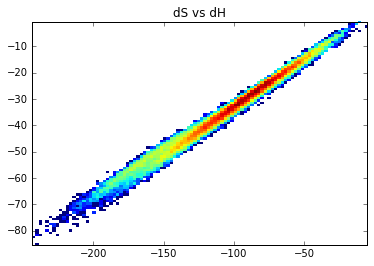

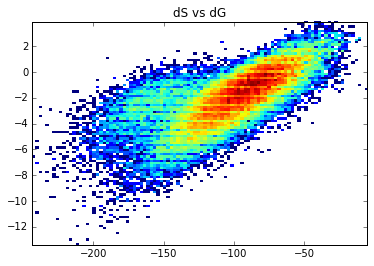

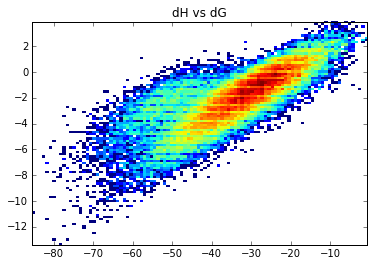

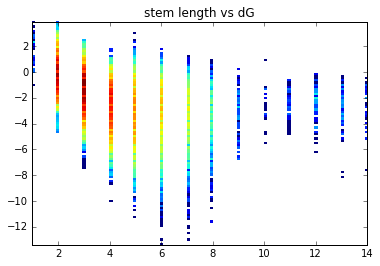

In [201]:
plt.hist2d(melting_temps, free_energies, bins=100, norm=LogNorm())
plt.title('Tm vs dG')
plt.show()
plt.hist2d(melting_temps, fold_entropies, bins=100, norm=LogNorm())
plt.title('Tm vs dS')
plt.show()
plt.hist2d(melting_temps, fold_enthalpies, bins=100, norm=LogNorm())
plt.title('Tm vs dH')
plt.show()
plt.hist2d(fold_entropies, fold_enthalpies, bins=100, norm=LogNorm())
plt.title('dS vs dH')
plt.show()
plt.hist2d(fold_entropies, free_energies, bins=100, norm=LogNorm())
plt.title('dS vs dG')
plt.show()
plt.hist2d(fold_enthalpies, free_energies, bins=100, norm=LogNorm())
plt.title('dH vs dG')
plt.show()
plt.hist2d(hairpin_stems, free_energies, bins=100, norm=LogNorm())
plt.title('stem length vs dG')
plt.show()

In [223]:
exact_points = list(filter(lambda p: p.bowtie_result().exact_match(), points))
print(len(points))
print(len(exact_points))
exact_matches = [p.bowtie_result().exact_match() for p in exact_points]
locations = [[m.chromosome, m.index] for m in exact_matches]

64076
63072


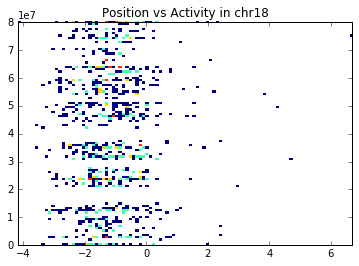

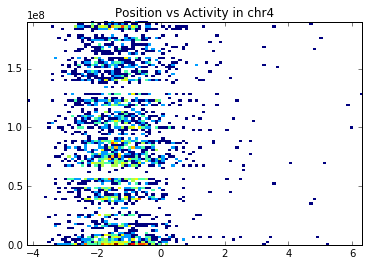

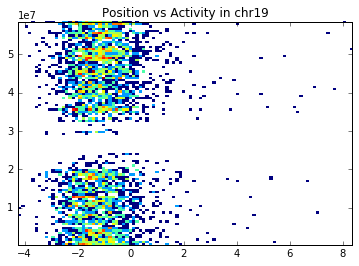

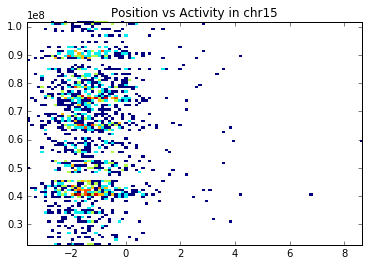

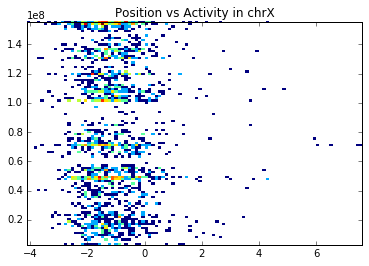

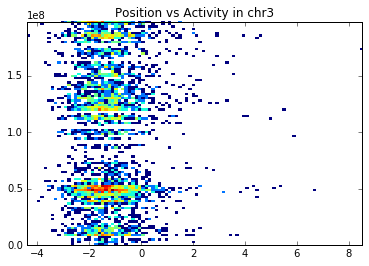

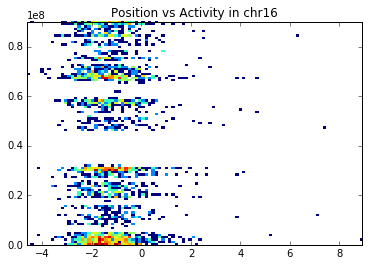

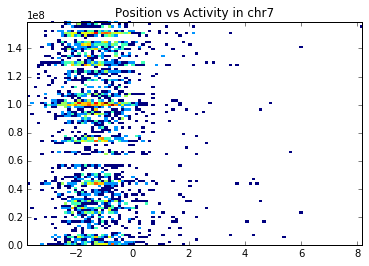

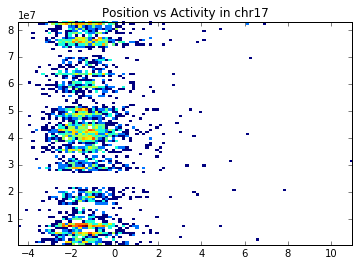

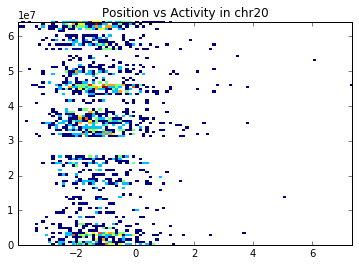

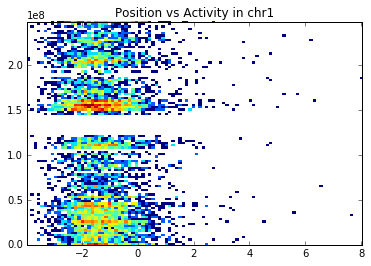

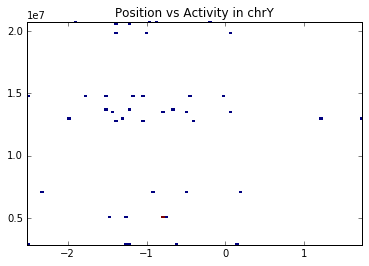

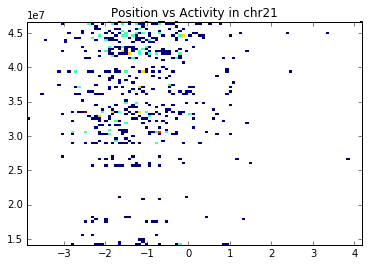

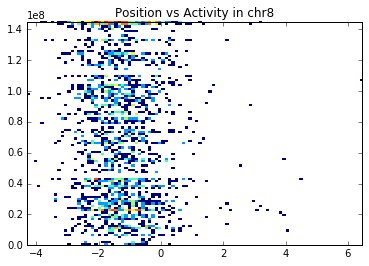

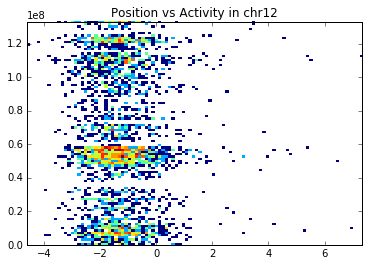

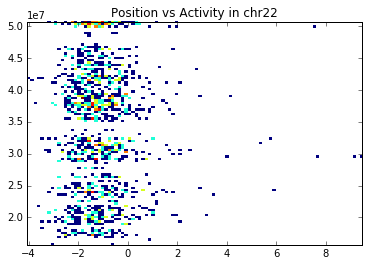

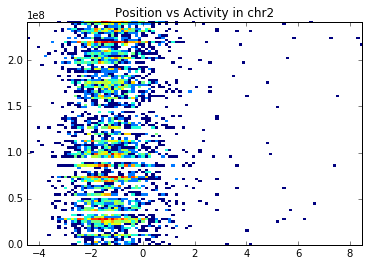

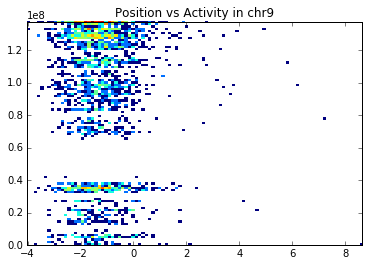

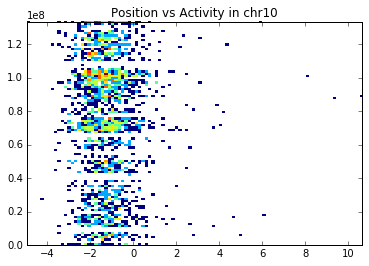

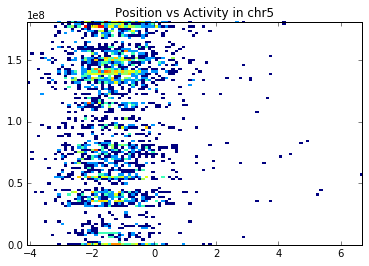

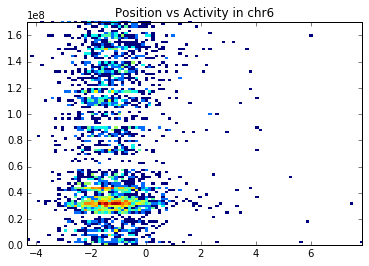

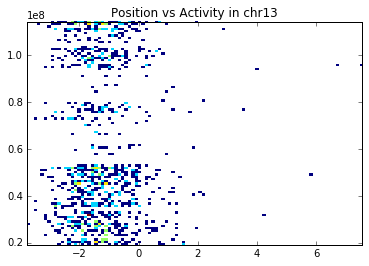

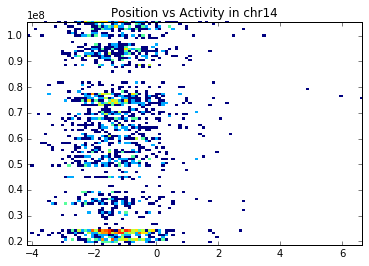

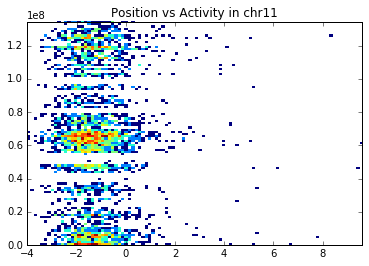

In [222]:
from collections import Counter
chromosome_counts = Counter(l[0] for l in locations)
for chromosome in chromosome_counts.keys():
    plt.title('Position vs Activity in ' + chromosome)
    local_positions = [l[1] for l in locations if l[0] == chromosome]
    local_activities = [p.d0_d14_plx_activity() for p in exact_points if p.bowtie_result().exact_match().chromosome == chromosome]
    plt.hist2d(local_activities, local_positions, bins=100, norm=LogNorm())
    plt.show()

Big surprise! Position within the chromosome doesn't seem to affect whether CRISPR works.